In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [46]:
#data_path = Path('/Volumes/My Book/Data_Analysis/Nasdaq') # set to e.g. external harddrive
DATA_STORE = '/Volumes/My Book/Data_Analysis/Nasdaq/assets.h5'

In [47]:
START = 2000
END = 2018

In [90]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [49]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [50]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7176 entries, AAMC to ZWS
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   marketcap  6759 non-null   object
 1   ipoyear    4076 non-null   object
 2   sector     6410 non-null   object
dtypes: object(3)
memory usage: 224.2+ KB


In [51]:
# Remove stocks duplicates and align index names for later joining.
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'


In [52]:
# Keep data with stock info. Get tickers with both price information and metdata.
shared = prices.columns.intersection(stocks.index)

In [53]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1795 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   marketcap  1795 non-null   object
 1   ipoyear    824 non-null    object
 2   sector     1780 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [54]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 1795 entries, A to ZUMZ
dtypes: float64(1795)
memory usage: 64.5 MB


In [55]:
assert prices.shape[1] == stocks.shape[0]

In [56]:
# To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency.
monthly_prices = prices.resample('M').last()

In [57]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 1795 entries, A to ZUMZ
dtypes: float64(1795)
memory usage: 3.0 MB


In [58]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 307217 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   307217 non-null  float64
 1   return_2m   307217 non-null  float64
 2   return_3m   307217 non-null  float64
 3   return_6m   307217 non-null  float64
 4   return_9m   307217 non-null  float64
 5   return_12m  307217 non-null  float64
dtypes: float64(6)
memory usage: 15.3+ MB


In [59]:
# Drop stocks with less than 10 years of data
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 282041 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   282041 non-null  float64
 1   return_2m   282041 non-null  float64
 2   return_3m   282041 non-null  float64
 3   return_6m   282041 non-null  float64
 4   return_9m   282041 non-null  float64
 5   return_12m  282041 non-null  float64
dtypes: float64(6)
memory usage: 14.1+ MB


In [60]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,282041.000000,282041.000000,282041.000000,282041.000000,282041.000000,282041.000000
mean,0.012666,0.009906,0.008957,0.007915,0.007483,0.007257
std,0.108740,0.077121,0.063199,0.045837,0.037701,0.032794
min,-0.312147,-0.240595,-0.202469,-0.152006,-0.123873,-0.106358
25%,-0.043390,-0.028320,-0.021749,-0.013023,-0.009382,-0.007315
50%,0.009834,0.010256,0.010240,0.009900,0.009572,0.009318
75%,0.064384,0.048373,0.041399,0.031683,0.027069,0.024558
max,0.407464,0.265929,0.210136,0.146513,0.119331,0.102254


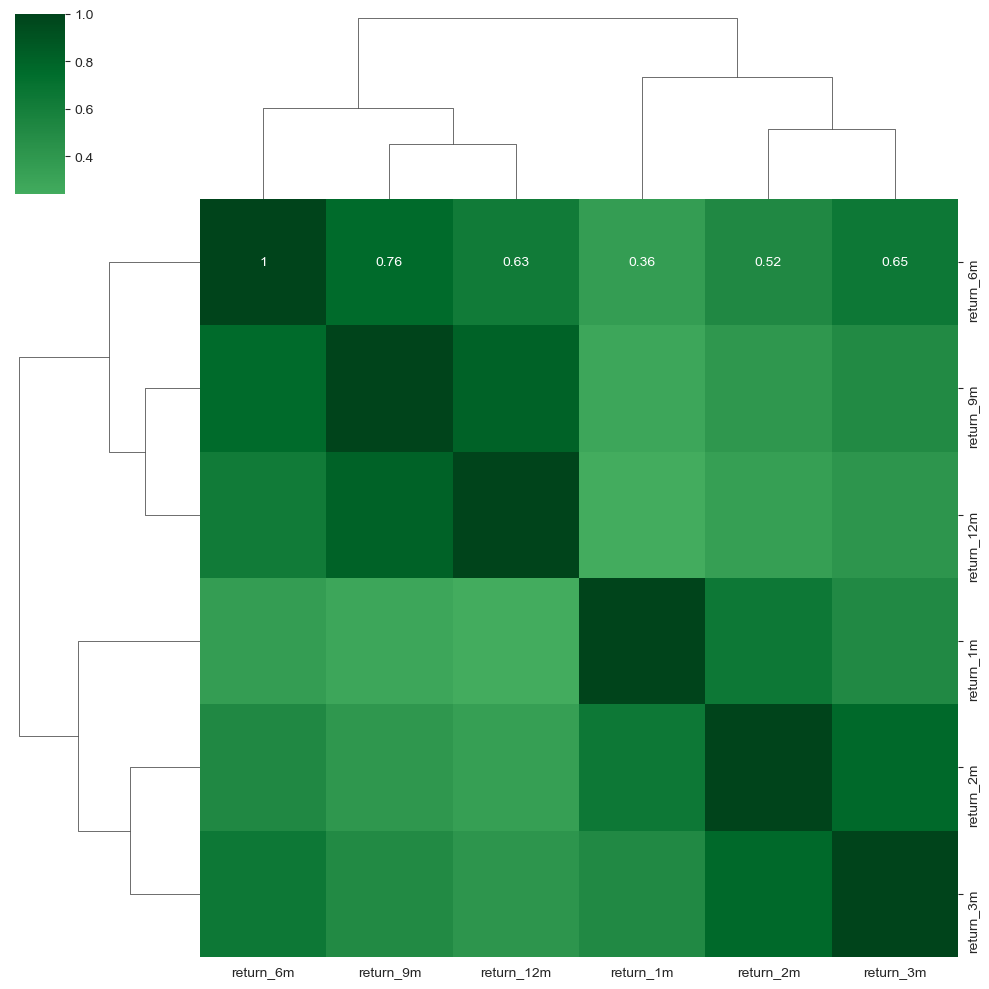

In [61]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Greens');

In [62]:
data.index.get_level_values('ticker').nunique()

1431

In [63]:
# Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2000-01-31 to 2023-12-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  288 non-null    float64
 1   SMB     288 non-null    float64
 2   HML     288 non-null    float64
 3   RMW     288 non-null    float64
 4   CMA     288 non-null    float64
dtypes: float64(5)
memory usage: 13.5 KB


In [64]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 282041 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     282041 non-null  float64
 1   SMB        282041 non-null  float64
 2   HML        282041 non-null  float64
 3   RMW        282041 non-null  float64
 4   CMA        282041 non-null  float64
 5   return_1m  282041 non-null  float64
dtypes: float64(6)
memory usage: 14.1+ MB


In [65]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [66]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,249128.000000,249128.000000,249128.000000,249128.000000,249128.000000,282041.000000
mean,0.963733,0.608535,0.116022,-0.031059,0.031575,1.491730
std,0.876592,1.211080,1.505593,1.788132,2.044738,3.132154
min,-9.732157,-10.192981,-15.198585,-22.239353,-15.497838,-32.261710
25%,0.463709,-0.121891,-0.678672,-0.895737,-1.016130,0.000000
50%,0.919090,0.520128,0.088515,0.059733,0.051939,1.223143
75%,1.415010,1.266986,0.905460,0.935195,1.103998,3.089208
max,9.601112,9.992596,14.751297,13.308557,14.448755,30.018644


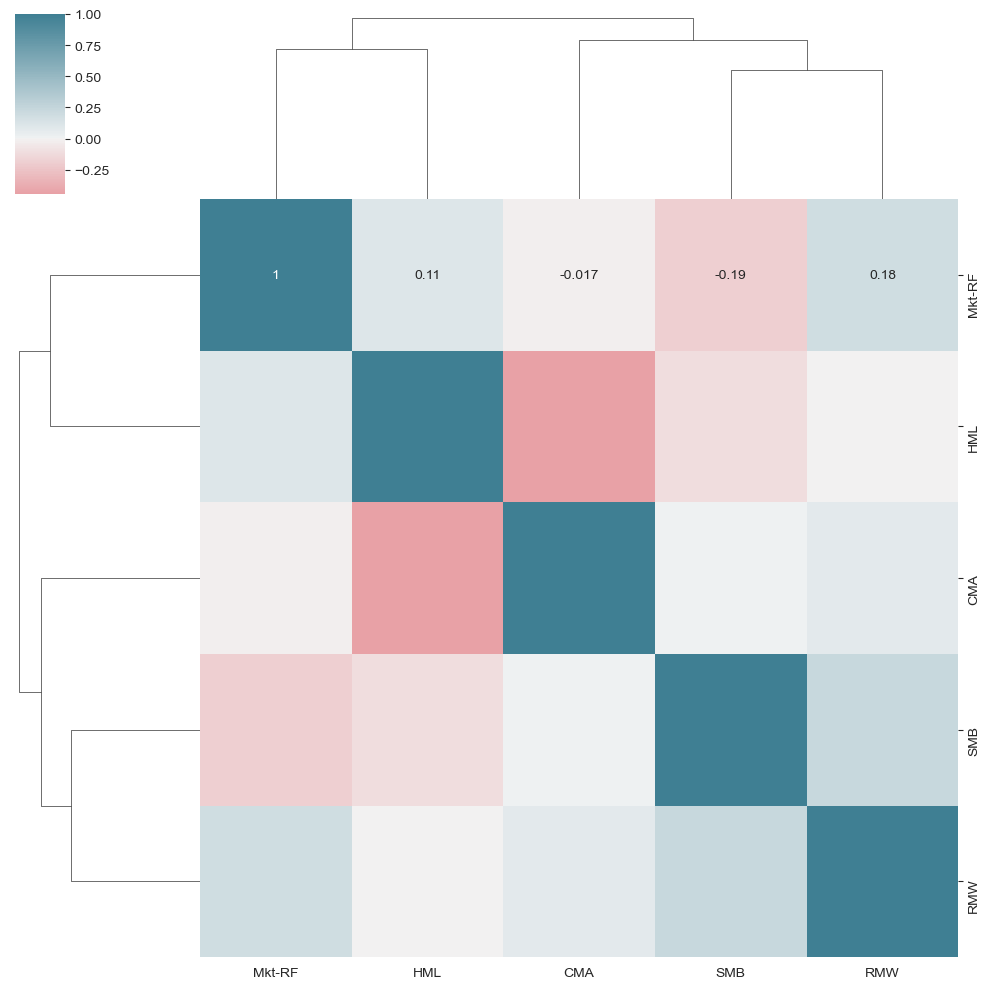

In [67]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [68]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 282041 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   282041 non-null  float64
 1   return_2m   282041 non-null  float64
 2   return_3m   282041 non-null  float64
 3   return_6m   282041 non-null  float64
 4   return_9m   282041 non-null  float64
 5   return_12m  282041 non-null  float64
 6   Mkt-RF      247697 non-null  float64
 7   SMB         247697 non-null  float64
 8   HML         247697 non-null  float64
 9   RMW         247697 non-null  float64
 10  CMA         247697 non-null  float64
dtypes: float64(11)
memory usage: 32.9+ MB


return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.312147  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.240595  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   

                   return_12m  Mkt-RF  SMB  HML  RMW  CMA  
ticker date                                                
A      2001-01-31   -0.015988     NaN  NaN  NaN  NaN  NaN  
       2001-02-28   -0.084537     NaN  NaN  NaN  NaN  NaN  
       2001-03-31   -0.096606     NaN  NaN  NaN  NaN  NaN  
       2001-04-30   -0.066102     NaN  NaN  NaN  NaN  NaN  
       2001-05-31   -0.063425     NaN  NaN  NaN  NaN  NaN

In [69]:
data.loc[:, factors] = data.groupby('ticker', as_index=False, group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 282041 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   282041 non-null  float64
 1   return_2m   282041 non-null  float64
 2   return_3m   282041 non-null  float64
 3   return_6m   282041 non-null  float64
 4   return_9m   282041 non-null  float64
 5   return_12m  282041 non-null  float64
 6   Mkt-RF      282041 non-null  float64
 7   SMB         282041 non-null  float64
 8   HML         282041 non-null  float64
 9   RMW         282041 non-null  float64
 10  CMA         282041 non-null  float64
dtypes: float64(11)
memory usage: 32.9+ MB


In [70]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

In [71]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

In [72]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 282041 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      282041 non-null  float64
 1   return_2m      282041 non-null  float64
 2   return_3m      282041 non-null  float64
 3   return_6m      282041 non-null  float64
 4   return_9m      282041 non-null  float64
 5   return_12m     282041 non-null  float64
 6   Mkt-RF         282041 non-null  float64
 7   SMB            282041 non-null  float64
 8   HML            282041 non-null  float64
 9   RMW            282041 non-null  float64
 10  CMA            282041 non-null  float64
 11  momentum_2     282041 non-null  float64
 12  momentum_3     282041 non-null  float64
 13  momentum_6     282041 non-null  float64
 14  momentum_9     282041 non-null  float64
 15  momentum_12    282041 non-null  float64
 16  

In [73]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [74]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.312147      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.312147  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 282041 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      282041 non-null  float64
 1   return_2m      282041 non-null  float64
 2   return_3m      282041 non-null  float64
 3   return_6m      282041 non-null  float64
 4   return_9m      282041 non-null  float64
 5   return_12m     282041 non-null  float64
 6   Mkt-RF         282041 non-null  float64
 7   SMB            282041 non-null  float64
 8   HML            282041 non-null  float64
 9   RMW            282041 non-null  float64
 10  CMA            282041 non-null  float64
 11  momentum_2     282041 non-null  float64
 12  momentum_3     282041 non-null  float64
 13  momentum_6     282041 non-null  float64
 14  momentum_9     282041 non-null  float64
 15  momentum_12    282041 non-null  float64
 16  

In [76]:
# We use quintiles of IPO year as a proxy for company age.
data = (data
        .join(pd.qcut(stocks.ipoyear.astype(float), q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

In [77]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1795 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   marketcap  1795 non-null   object
 1   ipoyear    824 non-null    object
 2   sector     1780 non-null   object
dtypes: object(3)
memory usage: 120.6+ KB


In [78]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2018-03-31 to 2001-01-31
Columns: 1431 entries, A to ZUMZ
dtypes: float64(1431)
memory usage: 2.3 MB


In [79]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'].astype(float))).dropna(axis=1, how='all')

In [80]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

In [81]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 282041 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      282041 non-null  float64
 1   return_2m      282041 non-null  float64
 2   return_3m      282041 non-null  float64
 3   return_6m      282041 non-null  float64
 4   return_9m      282041 non-null  float64
 5   return_12m     282041 non-null  float64
 6   Mkt-RF         282041 non-null  float64
 7   SMB            282041 non-null  float64
 8   HML            282041 non-null  float64
 9   RMW            282041 non-null  float64
 10  CMA            282041 non-null  float64
 11  momentum_2     282041 non-null  float64
 12  momentum_3     282041 non-null  float64
 13  momentum_6     282041 non-null  float64
 14  momentum_9     282041 non-null  float64
 15  momentum_12    282041 non-null  float64
 16  

In [88]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())
    #benchmark_rets = store['sp500/fred'].close.pct_change()
    benchmark_rets.name = 'S&P500'
    benchmark_rets.info()

<class 'pandas.io.pytables.HDFStore'>
File path: /Volumes/My Book/Data_Analysis/Nasdaq/assets.h5
/engineered_features            frame        (shape->[280610,33])  
/quandl/wiki/prices             frame        (shape->[15389314,12])
/quandl/wiki/stocks             frame        (shape->[1,2])        
/sp500/fred                     frame        (shape->[2607,1])     
/sp500/stocks                   frame        (shape->[503,7])      
/sp500/stooq                    frame        (shape->[18734,5])    
/us_equities/stocks             frame        (shape->[1,10])       
<class 'pandas.core.series.Series'>
DatetimeIndex: 2607 entries, 2014-02-18 to 2024-02-14
Series name: S&P500
Non-Null Count  Dtype  
--------------  -----  
2606 non-null   float64
dtypes: float64(1)
memory usage: 40.7 KB


In [84]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 282041 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 87 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   return_1m               282041 non-null  float64
 1   return_2m               282041 non-null  float64
 2   return_3m               282041 non-null  float64
 3   return_6m               282041 non-null  float64
 4   return_9m               282041 non-null  float64
 5   return_12m              282041 non-null  float64
 6   Mkt-RF                  282041 non-null  float64
 7   SMB                     282041 non-null  float64
 8   HML                     282041 non-null  float64
 9   RMW                     282041 non-null  float64
 10  CMA                     282041 non-null  float64
 11  momentum_2              282041 non-null  float64
 12  momentum_3              282041 non-null  float64
 13  